In [1]:
# 挂载 google 云盘
from google.colab import drive
drive.mount('/content/gdrive')
# 将文件路径指定为数据路径
import os
os.chdir('/content/gdrive/My Drive/comment')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# 第一次使用该语句可下载词向量数据集压缩包，其后可忽略，
# !wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip
# 解压缩
# !unzip 'wiki-news-300d-1M.vec.zip'

In [2]:
import numpy as np
from tqdm import tqdm #显示运行进度条
import io
fin = io.open('wiki-news-300d-1M.vec', 'r', encoding='utf-8')
embeddings = {} #词向量字典
word_features = 0 #词向量维度
count = 0
for line in tqdm(fin):
#     count += 1
#     if count > 100:
#         break
    tokens =  line.split()
    embeddings[tokens[0]] = np.asarray(tokens[1:], dtype='float')
    word_features = max(word_features, len(tokens[1:]))
fin.close()
print('找到 {} 个词向量'.format(len(embeddings)))
print('每个词向量的维度为 {}'.format(word_features))

999995it [01:31, 10900.31it/s]

找到 999995 个词向量
每个词向量的维度为 300


In [0]:
# 找到 999995 个词向量
# 每个词向量的维度为 300

In [8]:
print('正在加载数据文件......')
import pandas as pd
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
print('训练集中一共有 {} 条评论'.format(train_data.shape[0]))
print('测试集中一共有 {} 条评论'.format(test_data.shape[0]))
print('训练集中前5个样本为：')
train_data.head()

正在加载数据文件......
训练集中一共有 159571 条评论
测试集中一共有 153164 条评论
训练集中前5个样本为：


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [26]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


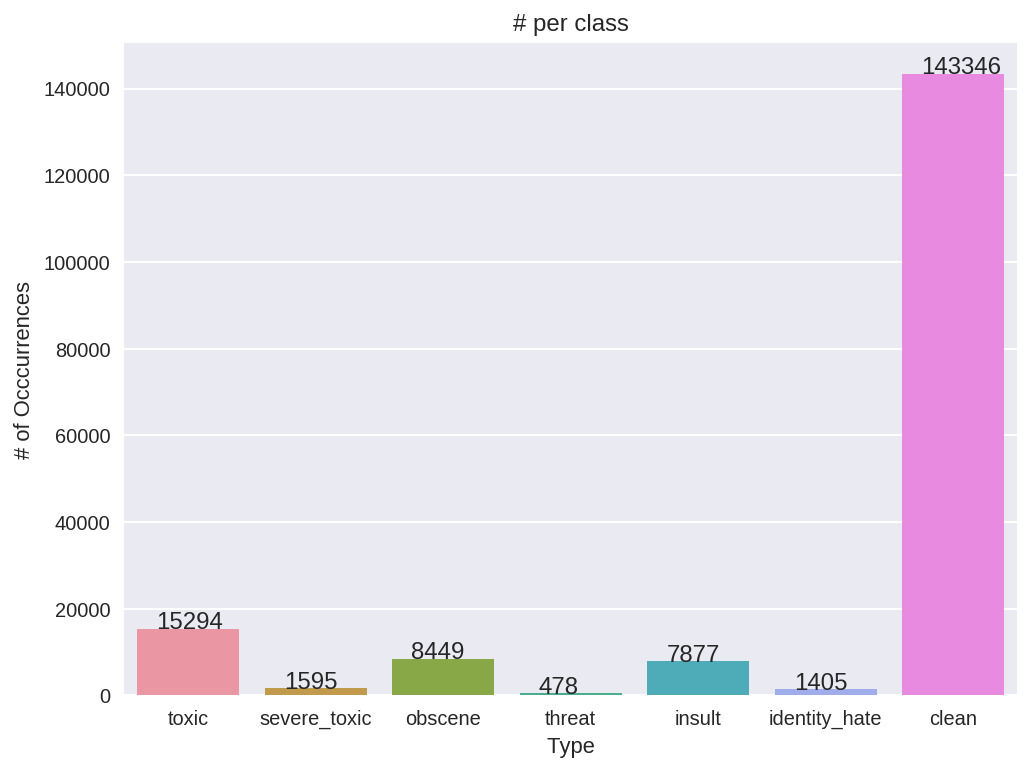

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sb
import matplotlib.pyplot as plt
# 训练集样本分布可视化
stats = {}
labels = train_data.columns[2:].tolist()
for label in labels:
    stats[label] = train_data[train_data[label] == 1][label].count()
    
col_sum = train_data[labels].apply(lambda x: x.sum(), axis=1)
stats['clean'] = (col_sum == 0).sum()
x = list(stats.keys())
y = list(stats.values())
sb.set(rc={"figure.figsize": (8, 6)})
sb.barplot(x, y)
plt.title('# per class')
plt.xlabel('Type')
plt.ylabel('# of Occcurrences')
for a,b in enumerate(y):
    plt.text(a-0.25, b+0.05, s=b)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


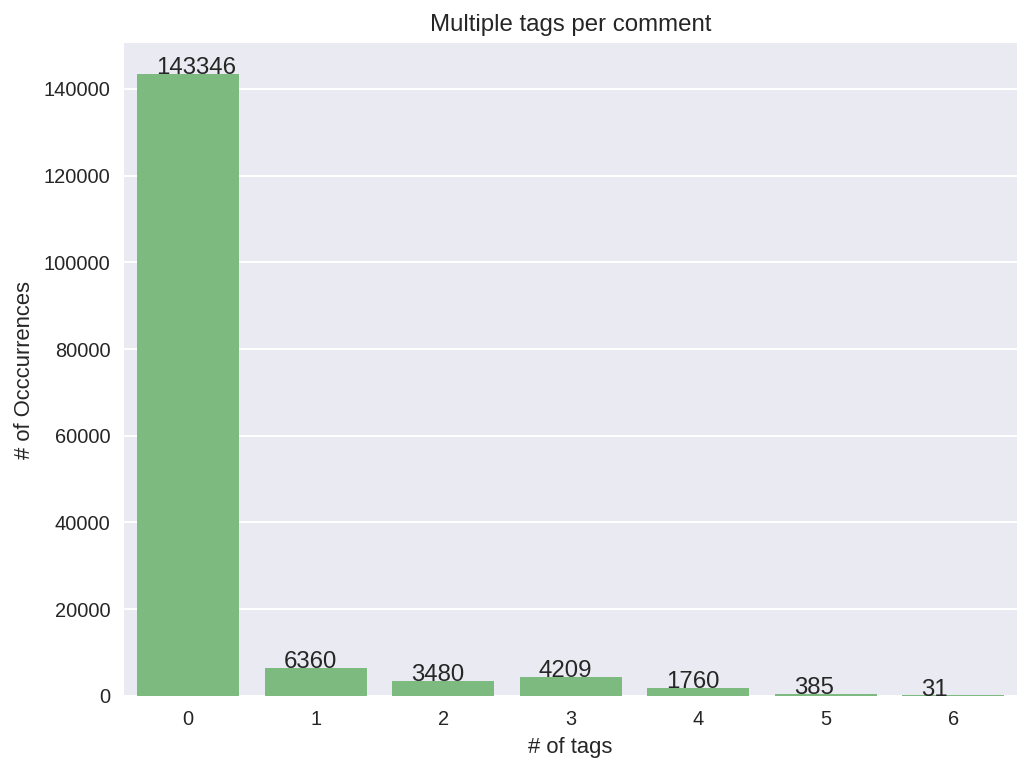

In [10]:
tag_num = {}
for count in range(len(labels)+1):
    tag_num[count] = (col_sum == count).sum()
x = list(tag_num.keys())
y = list(tag_num.values())
sb.set(rc={"figure.figsize": (8, 6)})
sb.barplot(x, y, palette=sb.color_palette("Greens", 1))
plt.title('Multiple tags per comment')
plt.xlabel('# of tags')
plt.ylabel('# of Occcurrences')
for a,b in enumerate(y):
    plt.text(a-0.25, b+0.05, s=b)

No handles with labels found to put in legend.


最长的评论字数为：2273
68% 的评论少于 169 字


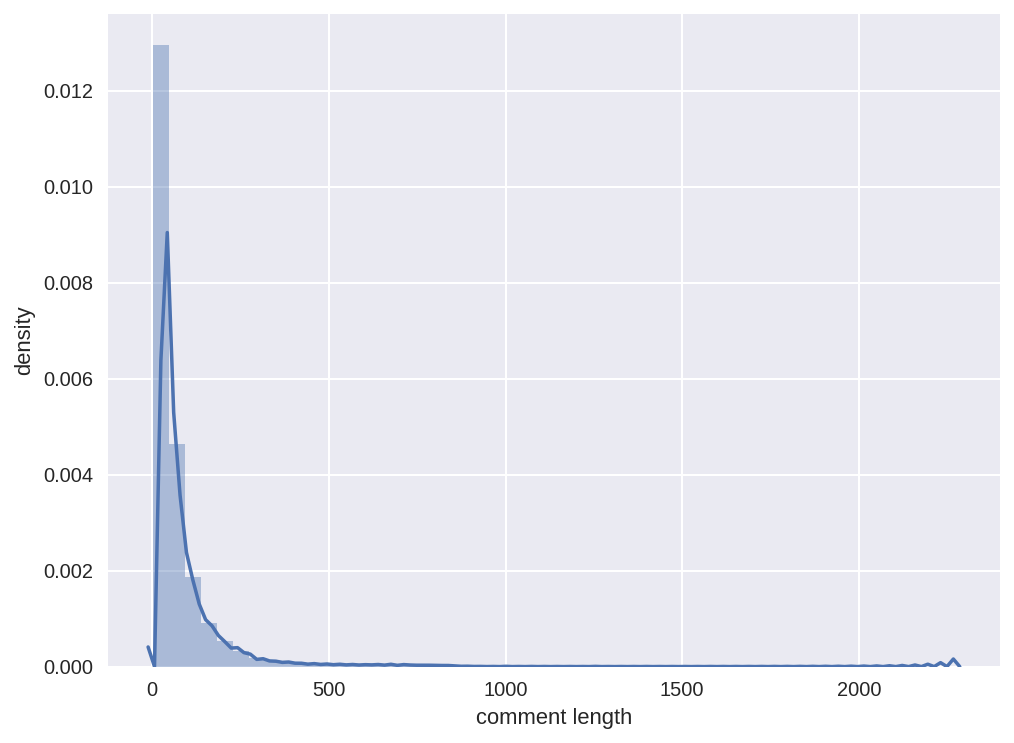

In [11]:
import numpy as np
# 评论长度分布可视化
comment_len = train_data['comment_text'].apply(lambda x: len(x.split(' ')))
# 位于长度一个标准偏差的位置的评论长度
maxlen = np.ceil(np.mean(comment_len) + 1*np.std(comment_len)).astype('int')
sb.distplot(comment_len)
# plt.axvline(x=maxlen, color='k', linestyle='--', label='95% of the comments')
plt.xlabel('comment length'); 
plt.ylabel('density');
plt.legend()
print('最长的评论字数为：{}'.format(np.max(comment_len)))
print('68% 的评论少于 {} 字'.format(maxlen))

In [15]:
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import RegexpTokenizer 
import nltk
nltk.download('stopwords')
import string
import random

from nltk.corpus import stopwords
# 过滤掉停止词及标点
stop_words = set(stopwords.words())
stop_words.update(string.punctuation)

train_refined, test_refined = [], []
# 元素化评论
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
# 过滤评论中停止词及标点
for line in train_data['comment_text']:
    train_refined.append(' '.join([word for word in tokenizer.tokenize(line) if word not in stop_words]))
for line in test_data['comment_text']:
    test_refined.append(' '.join([word for word in tokenizer.tokenize(line) if word not in stop_words]))
print(len(train_refined)==train_data.shape[0], len(test_refined)==test_data.shape[0])  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
True True


In [22]:
word_upper = 100000 # 词量上限
# 基于词频，保留前 100000 个词
tokenizer = Tokenizer(num_words=word_upper)
# tokenizer = Tokenizer()
# 创建评论词典，一个单词对应一个索引
tokenizer.fit_on_texts(train_refined + test_refined)
token_train, token_test = map(lambda x: tokenizer.texts_to_sequences(x), [train_refined, test_refined])
word_index = tokenizer.word_index
print('评论中的词汇量为 {}'.format(len(word_index)))

评论中的词汇量为 371465


In [0]:
from keras.preprocessing import sequence
seq_train, seq_test = map(lambda x: sequence.pad_sequences(x, maxlen=maxlen), [token_train, token_test] )

In [26]:
feature_matrix = np.zeros((min(word_upper, len(word_index)), word_features))
print(feature_matrix.shape)
for word, index in word_index.items():
    word_vec = embeddings.get(index)
    if word_vec is not None:
        feature_matrix[index] = word_vec

(100000, 300)


In [98]:
from keras.models import Sequential
from keras.layers import Embedding, GlobalAveragePooling1D, GlobalMaxPooling1D, Conv1D, GlobalAveragePooling1D
from keras.layers import Dropout, Dense, Activation
from keras import optimizers, metrics
from keras import regularizers
filters = 16
weight_decay = 1e-4
model = Sequential()
model.add(Embedding(word_upper, 
                    word_features,
                    input_length = maxlen,
                    weights=[feature_matrix],
                    trainable=False))
# model.add(Conv1D(filters, kernel_size = 5, activation='relu'))
# model.add(GlobalAveragePooling1D())
# model.add(Dropout(0.2))
# model.add(Dense(len(labels), activation='softmax'))

# model.add(Conv1D(filters, kernel_size = 5, activation='relu'))
# model.add(MaxPooling1D(2))
# model.add(Conv1D(filters, kernel_size = 5, activation='relu'))
# model.add(GlobalMaxPooling1D())
# model.add(Dropout(0.2))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(len(labels), activation='softmax'))
# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy']
#              )
model.add(Conv1D(filters, 5, activation='relu'))
# model.add(MaxPooling1D(2))
# model.add(Conv1D(filters, 5, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(labels), activation='softmax'))  #multi-label (k-hot encoding)

# adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 169, 300)          30000000  
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 165, 16)           24016     
_________________________________________________________________
global_average_pooling1d_5 ( (None, 16)                0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_27 (Dense)             (None, 6)                 198       
Total params: 30,024,758
Trainable params: 24,758
Non-trainable params: 30,000,000
___________________________________________________________

In [0]:
from keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor='val_loss', 
                          min_delta=0.001, 
                          patience=5, 
                          verbose=1, 
                          mode='min')]
# monitor: 被监测的数据。
# min_delta: 在被监测的数据中被认为是提升的最小变化， 例如，小于 min_delta 的绝对变化会被认为没有提升。
# patience: 没有进步的训练轮数，在这之后训练就会被停止。
# verbose: 详细信息模式。
# mode: {auto, min, max} 其中之一。 在 min 模式中， 当被监测的数据停止下降，训练就会停止；在 max 模式中，当被监测的数据停止上升，训练就会停止；在 auto 模式中，方向会自动从被监测的数据的名字中判断出来。

In [100]:
y_train = train_data[labels].values
batch_size = 128
epochs = 10
hist = model.fit(seq_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks,
                validation_split=0.25,
                shuffle=True, verbose=1)
# 把所有事件都记录到 History 对象的回调函数。
# 这个回调函数被自动启用到每一个 Keras 模型。History 对象会被模型的 fit 方法返回。

# batch_size = 256
# epochs = 3

# X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.95, random_state=233)
# RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)

# hist = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
#                  callbacks=[RocAuc], verbose=2)


Train on 119678 samples, validate on 39893 samples
Epoch 1/10
119678/119678 [==============================] - 14s 118us/step - loss: 0.3461 - acc: 0.9942 - val_loss: 0.3188 - val_acc: 0.9941
Epoch 2/10
119678/119678 [==============================] - 12s 97us/step - loss: 0.3090 - acc: 0.9942 - val_loss: 0.3051 - val_acc: 0.9941
Epoch 3/10
119678/119678 [==============================] - 11s 96us/step - loss: 0.3025 - acc: 0.9942 - val_loss: 0.3027 - val_acc: 0.9941
Epoch 4/10
119678/119678 [==============================] - 12s 99us/step - loss: 0.3012 - acc: 0.9942 - val_loss: 0.3020 - val_acc: 0.9941
Epoch 5/10
119678/119678 [==============================] - 12s 97us/step - loss: 0.3008 - acc: 0.9942 - val_loss: 0.3018 - val_acc: 0.9941
Epoch 6/10
119678/119678 [==============================] - 12s 96us/step - loss: 0.3007 - acc: 0.9942 - val_loss: 0.3017 - val_acc: 0.9941
Epoch 7/10
119678/119678 [==============================] - 12s 96us/step - loss: 0.3007 - acc: 0.9942 - val

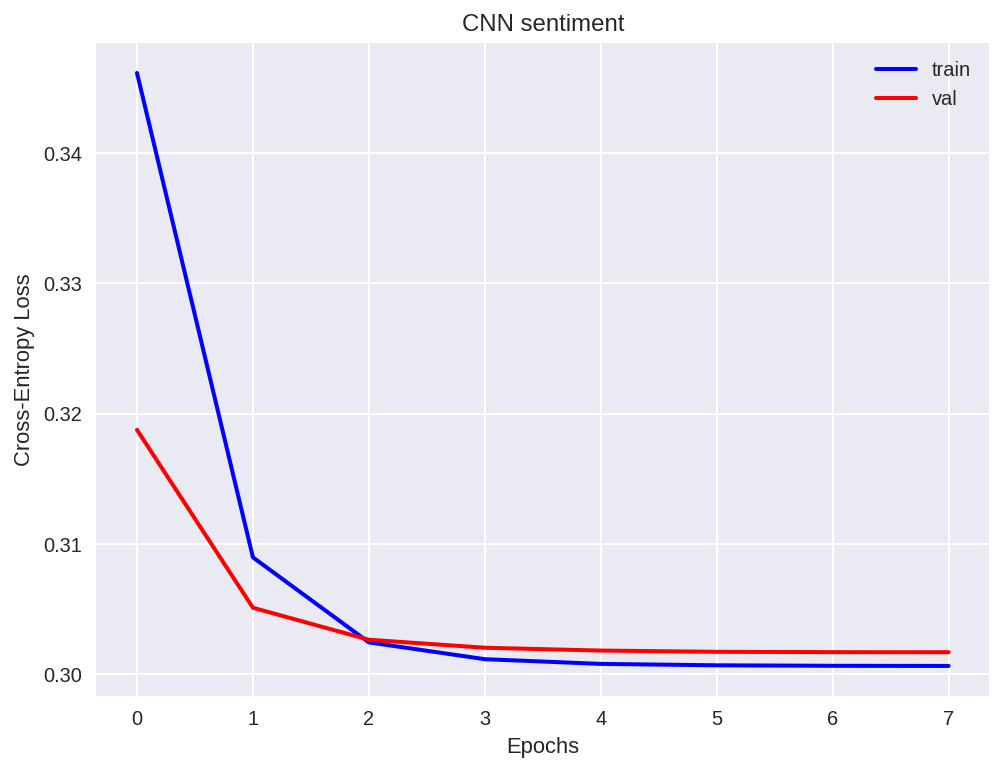

In [104]:
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

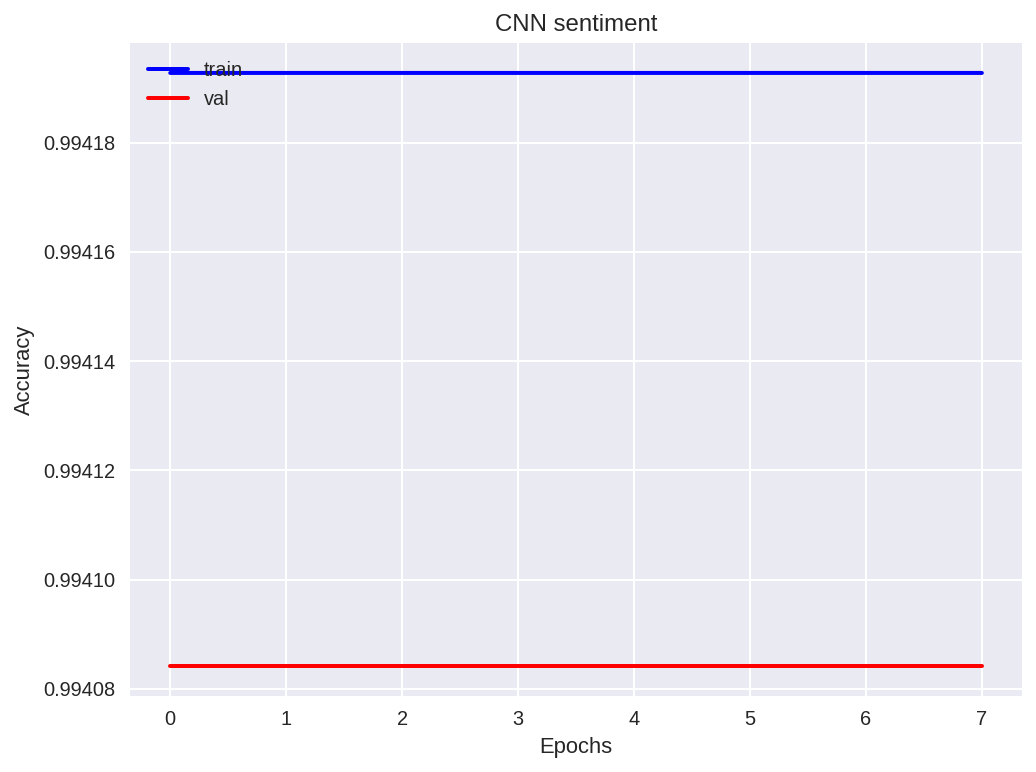

In [108]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
# plt.ylim((0.96,0.97))
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [0]:
# y_test = model.predict(seq_test)